# ED LOS PREPROCESSING

## Load Libraries + Dataset

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from keras.models import Sequential
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor





In [46]:
# Load the dataset
df_master = pd.read_csv('master_dataset_new.csv')

In [47]:
pd.set_option('display.max_columns', 200) 
df_master

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcomplaint,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,time_to_microbio_event_hrs,microbiology_event,time_to_med_event_hr,med_event
0,0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,Other,2180,52,False,0 days 04:13:00,NaN,NaN,False,True,False,0,0,0,2180-06-26 15:54:00,50 days 16:24:00,False,0,0,0,0,0,0,4.22,NaN,50.68,98.4,70.0,16.0,97.0,106.0,63.0,0.0,3.0,"Abd pain, Abdominal distention",False,True,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,97.7,79.0,16.0,98.0,107.0,60.0,0.0,0.0,9.0,10.92,1.0,2.37,1.0
1,1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,Medicaid,2180,52,False,0 days 05:37:00,NaN,NaN,False,True,False,0,1,1,2180-07-22 16:24:00,25 days 18:53:00,False,0,1,1,0,0,0,5.62,NaN,25.79,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,Abdominal distention,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,97.9,86.0,17.0,93.0,96.0,57.0,5.0,3.0,12.0,6.80,1.0,3.33,1.0
2,3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,52,2180,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52,False,0 days 13:30:00,2180-07-23 14:00:00,0 days 08:06:00,True,True,True,1,2,2,2180-07-23 05:54:00,0 days 00:00:00,True,1,2,2,0,0,0,13.50,8.1,0.00,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0,Hypotension,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,98.2,85.0,18.0,98.0,81.0,38.0,0.0,2.0,14.0,13.68,1.0,11.53,1.0
3,4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52,False,0 days 08:06:00,2180-07-23 14:00:00,0 days 00:00:00,True,True,True,2,3,3,2180-08-05 20:58:00,13 days 06:58:00,False,1,2,2,0,0,0,8.10,0.0,13.29,98.7,77.0,16.0,98.0,96.0,50.0,13.0,2.0,"Abdominal distention, Abd pain, LETHAGIC",Fa

## apply exclusion critea

In [48]:
df_master_impute = df_master.copy()

In [49]:
# Drop rows with negative LOS values or age less than 18

df_master_impute = df_master_impute[(df_master_impute['ed_los_hours'] >= 0) & (df_master_impute['age'] >= 18)]



In [50]:
#Drop observations with LOS greater than 24 hours & less than 0.5hr

# Count initial number of rows
initial_count = len(df_master_impute)

# Retain only rows where LOS is less than or equal to 24 hours
df_master_impute = df_master_impute[df_master_impute['ed_los_hours'] <= 24]
count_after_24_hours_filter = len(df_master_impute)
dropped_more_than_24 = initial_count - count_after_24_hours_filter
print(f"Number of values dropped for LOS > 24 hours: {dropped_more_than_24}")

# Retain only rows where LOS is greater than or equal to 0.5 hours
df_master_impute = df_master_impute[df_master_impute['ed_los_hours'] >= 0.5]
count_after_0_5_hours_filter = len(df_master_impute)
dropped_less_than_0_5 = count_after_24_hours_filter - count_after_0_5_hours_filter
print(f"Number of values dropped for LOS < 0.5 hours: {dropped_less_than_0_5}")


Number of values dropped for LOS > 24 hours: 11896
Number of values dropped for LOS < 0.5 hours: 2258


In [51]:
# Step 2: Drop observations with LOS greater than 24 hours & less than 0.5hr
# Retain only rows where LOS is less than or equal to 24 hours
df_master_impute = df_master_impute[df_master_impute['ed_los_hours'] <= 24]
df_master_impute = df_master_impute[(df_master_impute['ed_los_hours'] >= 0.5)]

In [52]:
df_master_impute

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcomplaint,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,time_to_microbio_event_hrs,microbiology_event,time_to_med_event_hr,med_event
0,0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,Other,2180,52,False,0 days 04:13:00,NaN,NaN,False,True,False,0,0,0,2180-06-26 15:54:00,50 days 16:24:00,False,0,0,0,0,0,0,4.22,NaN,50.68,98.4,70.0,16.0,97.0,106.0,63.0,0.0,3.0,"Abd pain, Abdominal distention",False,True,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,97.7,79.0,16.0,98.0,107.0,60.0,0.0,0.0,9.0,10.92,1.0,2.37,1.0
1,1,10000032,22841357.0,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,Medicaid,2180,52,False,0 days 05:37:00,NaN,NaN,False,True,False,0,1,1,2180-07-22 16:24:00,25 days 18:53:00,False,0,1,1,0,0,0,5.62,NaN,25.79,98.9,88.0,18.0,97.0,116.0,88.0,10.0,3.0,Abdominal distention,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,97.9,86.0,17.0,93.0,96.0,57.0,5.0,3.0,12.0,6.80,1.0,3.33,1.0
2,3,10000032,29079034.0,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,52,2180,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52,False,0 days 13:30:00,2180-07-23 14:00:00,0 days 08:06:00,True,True,True,1,2,2,2180-07-23 05:54:00,0 days 00:00:00,True,1,2,2,0,0,0,13.50,8.1,0.00,97.8,87.0,14.0,97.0,71.0,43.0,7.0,2.0,Hypotension,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,98.2,85.0,18.0,98.0,81.0,38.0,0.0,2.0,14.0,13.68,1.0,11.53,1.0
3,4,10000032,29079034.0,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,Medicaid,2180,52,False,0 days 08:06:00,2180-07-23 14:00:00,0 days 00:00:00,True,True,True,2,3,3,2180-08-05 20:58:00,13 days 06:58:00,False,1,2,2,0,0,0,8.10,0.0,13.29,98.7,77.0,16.0,98.0,96.0,50.0,13.0,2.0,"Abdominal distention, Abd pain, LETHAGIC",Fa

## Enocde Variables & Feature Engineering 

### Encoding

In [91]:
# Create dummy variables for all categorical variables without dropping any category
race_dummies = pd.get_dummies(df_master_impute['race'], prefix='race', drop_first=False)
arrival_transport_dummies = pd.get_dummies(df_master_impute['arrival_transport'], prefix='arrival_transport', drop_first=False)
disposition_dummies = pd.get_dummies(df_master_impute['disposition'], prefix='disposition', drop_first=False)
insurance_dummies = pd.get_dummies(df_master_impute['insurance'], prefix='insurance', drop_first=False)

In [92]:
# Concatenate the dummy variables with the original DataFrame
df_master_impute = pd.concat([df_master_impute, race_dummies, arrival_transport_dummies, disposition_dummies, insurance_dummies  ], axis=1)
df_master_impute

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcomplaint,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,time_to_microbio_event_hrs,microbiology_event,time_to_med_event_hr,med_event,ed_los_outlier,gender_encoded,triage_temperature_iter,triage_heartrate_iter,triage_resprate_iter,triage_o2sat_iter,triage_sbp_iter,triage_dbp_iter,triage_pain_iter,triage_acuity_iter,ed_temperature_last_iter,ed_heartrate_last_iter,ed_resprate_last_iter,ed_o2sat_last_iter,ed_sbp_last_iter,ed_dbp_last_iter,ed_pain_last_iter,ed_los_hours_iter,race_AMERICAN INDIAN/ALASKA NATIVE,race_ASIAN,race_ASIAN - ASIAN INDIAN,race_ASIAN - CHINESE,race_ASIAN - KOREAN,race_ASIAN - SOUTH EAST ASIAN,race_BLACK/AFRICAN,race_BLACK/AFRICAN AMERICAN,race_BLACK/CAPE VERDEAN,race_BLACK/CARIBBEAN ISLAND,race_HISPANIC OR LATINO,race_HISPANIC/LATINO - CENTRAL AMERICAN,race_HISPANIC/LATINO - COLUMBIAN,race_HISPANIC/LATINO - CUBAN,race_HISPANIC/LATINO - DOMINICAN,race_HISPANIC/LATINO - GUATEMALAN,race_HISPANIC/LATINO - HONDURAN,race_HISPANIC/LATINO - MEXICAN,race_HISPANIC/LATINO - PUERTO RICAN,race_HISPANIC/LATINO - SALVADORAN,race_MULTIPLE RACE/ETHNICITY,race_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,race_OTHER,race_PATIENT DECLINED TO ANSWER,race_PORTUGUESE,race_SOUTH AMERICAN,race_UNABLE TO OBTAIN,race_UNKNOWN,race_WHITE,race_WHITE - BRAZILIAN,race_WHITE - EASTERN EUROPEAN,race_WHITE - OTHER EUROPEAN,race_WHITE - RUSSIAN,arrival_transport_AMBULANCE,arrival_transport_HELICOPTER,arrival_transport_OTHER,arrival_transport_UNKNOWN,arrival_transport_WALK IN,disposition_ADMITTED,disposition_ELOPED,disposition_EXPIRED,disposition_HOME,disposition_LEFT AGAINST MEDICAL ADVICE,disposition_LEFT WITHOUT BEING SEEN,disposition_OTHER,disposition_TRANSFER,insurance_Medicaid,insurance_Medicare,insurance_Other
0,0,10000032,22595853.0,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,52,2180,2180-09-09,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,Other,2180,52,False,0 days 04:13:00,NaN,NaN,False,True,False,0,0,0,2180-06-26 15:54:00,50 days 16:24:00,False,0,0,0,0,0,0,4.22,NaN,50.68,36.888889,70.0,16.0,97.0,106.0,63.0,0.0,3.0,"Abd pain, Abdominal distention",False,True,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.500000,79.0,16.0,98.0,107.0,60.0,0.0,0.0,9.0,10.92,1.0,2.37,1.0,1,0,36.888889,70.000000,16.000000,97.000000,106.000000,63.00000,0.000000,3.000000,36.500000,79.0,16.0,98.000000,107.0,60.0

In [93]:
#create mappings for dummy variables

# Define the mapping dictionary
disposition_mapping = {
    'HOME': 0,
    'ADMITTED': 1,
    'TRANSFER': 2,
    'LEFT WITHOUT BEING SEEN': 3,
    'ELOPED': 4,
    'OTHER': 5,
    'LEFT AGAINST MEDICAL ADVICE': 6,
    'EXPIRED': 7
}

# Apply the mapping to encode the variable
df_master_impute['disposition_encoded'] = df_master_impute['disposition'].map(disposition_mapping)


# Define the mapping dictionary
arrival_transport_mapping = {
    'WALK IN': 0,
    'AMBULANCE': 1,
    'UNKNOWN': 2,
    'OTHER': 3,
    'HELICOPTER': 4
}

# Apply the mapping to encode the variable
df_master_impute['arrival_transport_encoded'] = df_master_impute['arrival_transport'].map(arrival_transport_mapping)

# Mapping for manual encoding
race_mapping = {
    'WHITE': 0,
    'BLACK/AFRICAN AMERICAN': 1,
    'OTHER': 2,
    'HISPANIC/LATINO - PUERTO RICAN': 3,
    'WHITE - OTHER EUROPEAN': 4,
    'HISPANIC/LATINO - DOMINICAN': 5,
    'BLACK/CAPE VERDEAN': 6,
    'ASIAN - CHINESE': 7,
    'ASIAN': 8,
    'UNKNOWN': 9,
    'WHITE - RUSSIAN': 10,
    'BLACK/AFRICAN': 11,
    'BLACK/CARIBBEAN ISLAND': 12,
    'HISPANIC OR LATINO': 13,
    'HISPANIC/LATINO - GUATEMALAN': 14,
    'ASIAN - ASIAN INDIAN': 15,
    'ASIAN - SOUTH EAST ASIAN': 16,
    'HISPANIC/LATINO - SALVADORAN': 17,
    'WHITE - BRAZILIAN': 18,
    'PORTUGUESE': 19,
    'WHITE - EASTERN EUROPEAN': 20,
    'HISPANIC/LATINO - COLUMBIAN': 21,
    'HISPANIC/LATINO - MEXICAN': 22,
    'SOUTH AMERICAN': 23,
    'AMERICAN INDIAN/ALASKA NATIVE': 24,
    'HISPANIC/LATINO - HONDURAN': 25,
    'HISPANIC/LATINO - CUBAN': 26,
    'HISPANIC/LATINO - CENTRAL AMERICAN': 27,
    'ASIAN - KOREAN': 28,
    'PATIENT DECLINED TO ANSWER': 29,
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 30,
    'MULTIPLE RACE/ETHNICITY': 31,
    'UNABLE TO OBTAIN': 32
}

# Encode 'race' variable using the mapping
df_master_impute['race_encoded'] = df_master_impute['race'].map(race_mapping)



In [94]:
#Gender

# Encode 'gender' variable as 0 for female and 1 for male
df_master_impute['gender_encoded'] = df_master_impute['gender'].map({'F': 0, 'M': 1})
print(df_master_impute['gender_encoded'].value_counts())

gender_encoded
0    222318
1    188609
Name: count, dtype: int64


In [95]:
#Chief Complaint

# Convert True/False columns to binary (0 or 1)
binary_columns = ['chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 
                  'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 
                  'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 
                  'chiefcom_dizziness']

for column in binary_columns:
    df_master_impute[column] = df_master_impute[column].astype(int)

# Display the first few rows to verify the encoding
print(df_master_impute[binary_columns].head())

   chiefcom_chest_pain  chiefcom_abdominal_pain  chiefcom_headache  \
0                    0                        1                  0   
1                    0                        0                  0   
2                    0                        0                  0   
3                    0                        1                  0   
4                    0                        1                  0   

   chiefcom_shortness_of_breath  chiefcom_back_pain  chiefcom_cough  \
0                             0                   0               0   
1                             0                   0               0   
2                             0                   0               0   
3                             0                   0               0   
4                             0                   0               0   

   chiefcom_nausea_vomiting  chiefcom_fever_chills  chiefcom_syncope  \
0                         0                      0                 0   
1       

### Feature Engineering 

In [96]:
#Charlson's Comorbidity Index (CCI)

def calculate_cci(row):
    cci_weights = {
        'MI': 1,
        'CHF': 1,
        'PVD': 1,
        'Stroke': 1,
        'Dementia': 1,
        'Pulmonary': 1,
        'Rheumatic': 1,
        'PUD': 1,
        'Liver1': 1,
        'DM1': 1,
        'DM2': 2,
        'Paralysis': 2,
        'Renal': 2,
        'Cancer1': 2,
        'Liver2': 3,
        'Cancer2': 6,
        'HIV': 6
    }
    
    cci_score = 0
    for condition, weight in cci_weights.items():
        if row[f'cci_{condition}']:
            cci_score += weight
    return cci_score

# Apply the function to calculate CCI for each row (ED stay)
df_master_impute['cci_score'] = df_master_impute.apply(calculate_cci, axis=1)

In [97]:
# Define the weights for each ECI condition
eci_weights = {
    'Arrhythmia': 1,
    'Valvular': 3,
    'PHTN': 2,
    'PVD': 2,
    'HTN1': 1,
    'HTN2': 2,
    'Paralysis': 2,
    'NeuroOther': 1,
    'Pulmonary': 1,
    'DM1': 1,
    'DM2': 1,
    'Hypothyroid': 1,
    'Renal': 2,
    'Liver': 3,
    'PUD': 1,
    'HIV': 6,
    'Lymphoma': 2,
    'Tumor2': 2,
    'Tumor1': 1,
    'Rheumatic': 1,
    'Coagulopathy': 2,
    'Obesity': 1,
    'WeightLoss': 1,
    'FluidsLytes': 1,
    'BloodLoss': 1,
    'Anemia': 1,
    'Alcohol': 1,
    'Drugs': 1,
    'Psychoses': 3,
    'Depression': 1
}

# Define a function to calculate the ECI score for each row
def calculate_eci(row):
    eci_score = 0
    for condition, weight in eci_weights.items():
        if row[f'eci_{condition}']:
            eci_score += weight
    return eci_score

# 
# Apply the calculate_eci function row-wise to calculate ECI score for each patient
df_master_impute['eci_score'] = df_master_impute.apply(calculate_eci, axis=1)

# Now df_master contains a new column 'eci_score' representing the ECI score for each visit

In [58]:
#conver temp to Celcius

def convert_temp_to_celcius(df_master):
    for column in df_master.columns:
        column_type = column.split('_')[1] if len(column.split('_')) > 1 else None
        if column_type == 'temperature':
            # convert to Celsius
            df_master.loc[:, column] -= 32
            df_master.loc[:, column] *= 5/9
    return df_master

df_master = convert_temp_to_celcius(df_master_impute)

## Imputation of Missing values

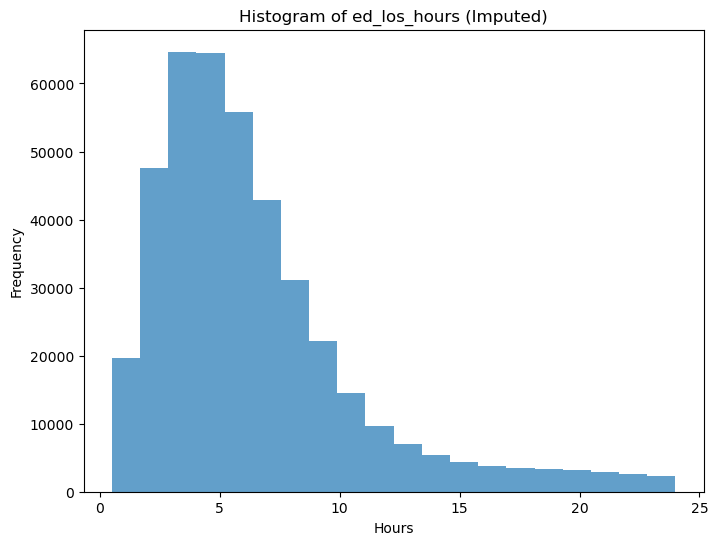

In [17]:
#first look at ed los
import matplotlib.pyplot as plt

# Create figure and axes for the histogram
fig, ax_hist = plt.subplots(figsize=(8, 6))

# Histogram
ax_hist.hist(df_master_impute['ed_los_hours'], bins=20, alpha=0.7)
ax_hist.set_title('Histogram of ed_los_hours (Imputed)')
ax_hist.set_xlabel('Hours')
ax_hist.set_ylabel('Frequency')

# Show histogram
plt.show()

from previous work we have found that MIMIC Extract and LOF missing value analysis work best combined with 
iterative imputation for Vital signs and ed los hours respectively

### determine outlier values 


#### vital_signs

In [59]:

vitals_cols = [
    'triage_temperature', 'triage_heartrate', 'triage_resprate',
    'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity',
    'ed_temperature_last', 'ed_heartrate_last', 'ed_resprate_last',
    'ed_o2sat_last', 'ed_sbp_last', 'ed_dbp_last', 'ed_pain_last'
]


In [60]:
# Extract the vital sign data
df_vitals = df_master_impute[vitals_cols]

In [61]:
print(df_vitals.isna().sum())


triage_temperature     22176
triage_heartrate       16007
triage_resprate        19207
triage_o2sat           19432
triage_sbp             17172
triage_dbp             17953
triage_pain            25670
triage_acuity           6274
ed_temperature_last    24723
ed_heartrate_last      17167
ed_resprate_last       17654
ed_o2sat_last          27803
ed_sbp_last            17398
ed_dbp_last            17398
ed_pain_last           48280
dtype: int64


In [62]:
# Define the valid range for vital signs based on previous analysis
vitals_valid_range = {
    'temperature': {'outlier_low': 14.2, 'valid_low': 26, 'valid_high': 45, 'outlier_high': 47},
    'heartrate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 350, 'outlier_high': 390},
    'resprate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 300, 'outlier_high': 330},
    'o2sat': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 100, 'outlier_high': 150},
    'sbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high': 375},
    'dbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high': 375},
    'pain': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 10, 'outlier_high': 10},
    'acuity': {'outlier_low': 1, 'valid_low': 1, 'valid_high': 5, 'outlier_high': 5}
}

In [63]:
# Display the count of outliers comprehensively
def display_outliers_count_new(df_master, vitals_valid_range):
    display_list = []

    for column in df_master.columns:
        column_type = column.split('_')[1] if len(column.split('_')) > 1 else None
        if column_type in vitals_valid_range:
            column_range = vitals_valid_range[column_type]
            display_list.append({
                'variable': column,
                '< outlier_low': len(df_master[df_master[column] < column_range['outlier_low']]),
                '[outlier_low, valid_low)': len(df_master[(column_range['outlier_low'] <= df_master[column]) & (df_master[column] < column_range['valid_low'])]),
                '[valid_low, valid_high]': len(df_master[(column_range['valid_low'] <= df_master[column]) & (df_master[column] <= column_range['valid_high'])]),
                '(valid_high, outlier_high)': len(df_master[(column_range['valid_high'] < df_master[column]) & (df_master[column] <= column_range['outlier_high'])]),
                '> outlier_high': len(df_master[df_master[column] > column_range['outlier_high']])
            })

    # Create a DataFrame from the list of dictionaries
    display_df = pd.DataFrame(display_list)
    return display_df

df_outlier_summary = display_outliers_count_new(df_vitals, vitals_valid_range)
print("Outlier Summary:")
df_outlier_summary

Outlier Summary:


,variable,< outlier_low,"[outlier_low, valid_low)","[valid_low, valid_high]","(valid_high, outlier_high)",> outlier_high
0,triage_temperature,459,28,388255,0,9
1,triage_heartrate,0,0,394914,0,6
2,triage_resprate,0,0,391717,0,3
3,triage_o2sat,0,0,391450,6,39
4,triage_sbp,0,0,393739,0,16
5,triage_dbp,0,0,392590,0,384
6,triage_pain,0,0,374353,0,10904
7,triage_acuity,0,0,404653,0,0
8,ed_temperature_last,744,42,385371,1,46
9,ed_heartrate_last,0,0,393760,0,0


In [64]:

# Step 1: Remove outliers and impute based on the valid range for each vital sign
def outlier_removal_imputation(column_type, vitals_valid_range):
    column_range = vitals_valid_range[column_type]
    def outlier_removal_imputation_single_value(x):
        if x < column_range['outlier_low'] or x > column_range['outlier_high']:
            # set as missing
            return np.nan
        elif x < column_range['valid_low']:
            # impute with nearest valid value
            return column_range['valid_low']
        elif x > column_range['valid_high']:
            # impute with nearest valid value
            return column_range['valid_high']
        else:
            return x
    return outlier_removal_imputation_single_value

def remove_outliers(df_master, vitals_valid_range):
    df_master = df_master.copy()  # Make a copy to avoid modifying the original DataFrame
    for column in df_master.columns:
        column_type = column.split('_')[1] if len(column.split('_')) > 1 else None
        if column_type in vitals_valid_range:
            df_master[column] = df_master[column].apply(outlier_removal_imputation(column_type, vitals_valid_range))
    return df_master



In [76]:
df_vitals_cleaned

,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last
0,36.888889,70.0,16.0,97.0,106.0,63.0,0.0,3.0,36.500000,79.0,16.0,98.0,107.0,60.0,0.0
1,37.166667,88.0,18.0,97.0,116.0,88.0,10.0,3.0,36.611111,86.0,17.0,93.0,96.0,57.0,5.0
2,36.555556,87.0,14.0,97.0,71.0,43.0,7.0,2.0,36.777778,85.0,18.0,98.0,81.0,38.0,0.0
3,37.055556,77.0,16.0,98.0,96.0,50.0,NaN,2.0,37.222222,96.0,18.0,97.0,86.0,45.0,NaN
4,37.444444,105.0,18.0,96.0,106.0,57.0,10.0,3.0,36.722222,91.0,18.0,99.0,98.0,60.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425080,37.000000,80.0,18.0,100.0,161.0,100.0,0.0,3.0,37.000000,75.0,16.0,99.0,123.0,82.0,0.0
425081,36.666667,91.0,16.0,99.0,148.0,90.0,5.0,2.0,36.333333,76.0,16.0,99.0,142.0,80.0,3.0
425082,37.111111,92.0,18.0,100.0,122.0,77.0,0.0,3.0,36.722222,72.0,16.0,100.0,131.0,92.0,0.0
425084,35.888889,112.0,18.0,100.0,110.0,82.0,4.0,2.0,36.722222,109.0,15.0,96.0,111.0,78.0,4.0


In [78]:

df_vitals_cleaned = remove_outliers(df_vitals, vitals_valid_range)

# Display the count of missing values after analysis and before imputation
print("Missing values before imputation:")
print(df_vitals_cleaned.isna().sum())

Missing values before imputation:
triage_temperature     22644
triage_heartrate       16013
triage_resprate        19210
triage_o2sat           19471
triage_sbp             17188
triage_dbp             18337
triage_pain            36574
triage_acuity           6274
ed_temperature_last    25513
ed_heartrate_last      17167
ed_resprate_last       17654
ed_o2sat_last          27812
ed_sbp_last            17399
ed_dbp_last            17649
ed_pain_last           48294
dtype: int64


In [81]:
# Reassign columns from df_vitals_cleaned back to df_master
for column in df_vitals_cleaned.columns:
    if column in df_master.columns:
        df_master[column] = df_vitals_cleaned[column]


In [82]:
df_master['triage_dbp'].describe()

count    392590.000000
mean         77.458206
std          14.946127
min           0.000000
25%          68.000000
50%          77.000000
75%          87.000000
max         375.000000
Name: triage_dbp, dtype: float64

#### ed los

In [101]:
#df_master

In [84]:


df_master_impute['ed_los_hours'].isna().sum()

0

In [85]:
# Use Local Outlier Factor (LOF) to detect outliers in ed_los_hours and set them to missing values (found to work best)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
df_master_impute['ed_los_outlier'] = lof.fit_predict(df_master_impute[['ed_los_hours']])
df_master_impute['ed_los_hours'] = np.where(df_master_impute['ed_los_outlier'] == -1, np.nan, df_master_impute['ed_los_hours'])

# Display outlier count
outlier_count = (df_master_impute['ed_los_outlier'] == -1).sum()
print(f'Number of outliers detected by LOF: {outlier_count}')

Number of outliers detected by LOF: 2969


In [86]:
df_master_impute['ed_los_hours'].isna().sum()


2969

imputinng the vital sings and ed los using iterative imputation whihc was found to be the best for our case

### impute

In [89]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Load the dataset
#df_master_impute = pd.read_csv('/mnt/data/df_master_new.csv')

# Select relevant variables for imputation
relevant_columns = [
    'triage_temperature', 'triage_heartrate', 'triage_resprate',
    'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity',
    'ed_temperature_last', 'ed_heartrate_last', 'ed_resprate_last',
    'ed_o2sat_last', 'ed_sbp_last', 'ed_dbp_last', 'ed_pain_last',
    'ed_los_hours', 'age', 'gender_encoded'
]
df_master_impute_1 = df_master_impute[relevant_columns]

# Step 1: Apply Iterative Imputer to impute missing values for vital signs and ed_los_hours using the relevant columns
iterative_imputer = IterativeImputer(random_state=0)

# Only fit and transform the columns that need imputation
columns_to_impute = [
    'triage_temperature', 'triage_heartrate', 'triage_resprate',
    'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity',
    'ed_temperature_last', 'ed_heartrate_last', 'ed_resprate_last',
    'ed_o2sat_last', 'ed_sbp_last', 'ed_dbp_last', 'ed_pain_last',
    'ed_los_hours'
]
df_to_impute = df_master_impute_1[columns_to_impute]

# Fit and transform only the columns that need to be imputed
df_imputed = iterative_imputer.fit_transform(df_to_impute)

# Add imputed columns back to the original dataframe with '_iter' as prefix
for idx, col in enumerate(columns_to_impute):
    df_master_impute[f'{col}_iter'] = df_imputed[:, idx]

# Check for missing values in the newly created columns
missing_values = df_master_impute.filter(like='_iter').isnull().sum()
print("Missing values in imputed columns:")
print(missing_values)

# Save the updated dataframe
#df_master_impute.to_csv('/mnt/data/df_master_imputed.csv', index=False)




Missing values in imputed columns:
triage_temperature_iter     0
triage_heartrate_iter       0
triage_resprate_iter        0
triage_o2sat_iter           0
triage_sbp_iter             0
triage_dbp_iter             0
triage_pain_iter            0
triage_acuity_iter          0
ed_temperature_last_iter    0
ed_heartrate_last_iter      0
ed_resprate_last_iter       0
ed_o2sat_last_iter          0
ed_sbp_last_iter            0
ed_dbp_last_iter            0
ed_pain_last_iter           0
ed_los_hours_iter           0
dtype: int64


### visualize

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the list of columns to compare
columns_to_compare = [
    'triage_temperature', 'triage_heartrate', 'triage_resprate',
    'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain', 'triage_acuity',
    'ed_temperature_last', 'ed_heartrate_last', 'ed_resprate_last',
    'ed_o2sat_last', 'ed_sbp_last', 'ed_dbp_last', 'ed_pain_last',
    'ed_los_hours'
]

# Plot original vs imputed distributions for each column
for col in columns_to_compare:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_master_impute[col], color='blue', label=f'Original {col}', kde=True, alpha=0.6)
    sns.histplot(df_master_impute[f'{col}_iter'], color='red', label=f'Imputed {col}_iter', kde=True, alpha=0.6)
    plt.title(f'Comparison of Original vs Imputed Distributions for {col}')
    plt.legend()
    plt.show()


In [98]:
# Save the updated dataframe
df_master_impute.to_csv('df_master_imputed_iter_new.csv', index=False)

In [99]:
#df_master_impute['triage_dbp'].describe()

count    392590.000000
mean         77.458206
std          14.946127
min           0.000000
25%          68.000000
50%          77.000000
75%          87.000000
max         375.000000
Name: triage_dbp, dtype: float64

In [100]:
#df_master_impute['triage_dbp_iter'].describe()

count    410927.000000
mean         77.395660
std          14.694691
min           0.000000
25%          68.000000
50%          77.000000
75%          86.194811
max         375.000000
Name: triage_dbp_iter, dtype: float64